In [2]:
# set the autoreload and the inline plotting for matplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# data manipulation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
# image manipulations
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk

In [5]:
# GIS related
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import shape, MultiPolygon, Polygon

In [11]:
# eo-learn related
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType, LoadFromDisk, SaveToDisk, SaveTask, LoadTask
from eolearn.mask import CloudMaskTask, AddValidDataMaskTask
from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask
from eolearn.geometry import VectorToRaster
from eolearn.io import SentinelHubInputTask, SentinelHubDemTask, SentinelHubEvalscriptTask, get_available_timestamps

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# Image manipulations
# Our water detector is going to be based on a simple threshold 
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# Loading polygon of nominal water extent
import shapely.wkt



In [13]:
# Sentinel Hub
from sentinelhub import BBox, CRS, DataCollection, MimeType, SentinelHubRequest, SHConfig

In [14]:
from flask import request

In [15]:
# water observatory backend
import sys
sys.path.append('./water-observatory-backend/src')
#from visualisation import plot_water_body
from geom_utils import get_bbox
from s2_water_extraction import get_water_level_optical
from visualisation import draw_multi, draw_poly

In [16]:
# other
import urllib.request as request
import json
from datetime import datetime
from shapely.wkt import loads

In [17]:
import datetime
from aenum import MultiValueEnum
from matplotlib.colors import ListedColormap, BoundaryNorm

In [18]:
ID = 40308 # id of chosen waterbody from Blue Dot water observatory

In [19]:
# function for obtaining the nominal water geometry from the water observatory API
def get_nominal_geometry(ID):
    wb_url = f'https://water.blue-dot-observatory.com/api/waterbodies/{ID}/index.html'
    with request.urlopen(wb_url) as url:
        wb_data = json.loads(url.read().decode())
        nominal_outline = shape(wb_data['nominal_outline']['geometry'])
    return nominal_outline

In [20]:
# utility function for plotting the geometry
def plot_geometry(geom, ax = None, **kwargs):
    
    if geom is None:
        return
    if geom.exterior is None:
        return
    
    x,y = geom.exterior.xy

    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)
        
    ax.plot(x, y, **kwargs)

In [21]:
# get the nominal geometry
geom = get_nominal_geometry(ID)

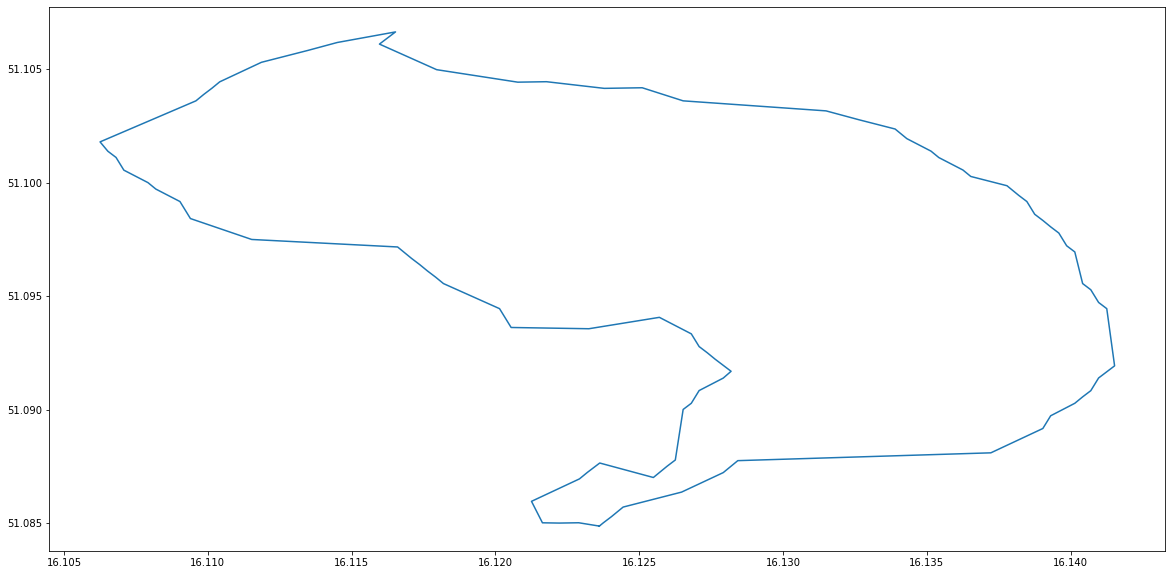

In [22]:
# and plot it
plot_geometry(geom)

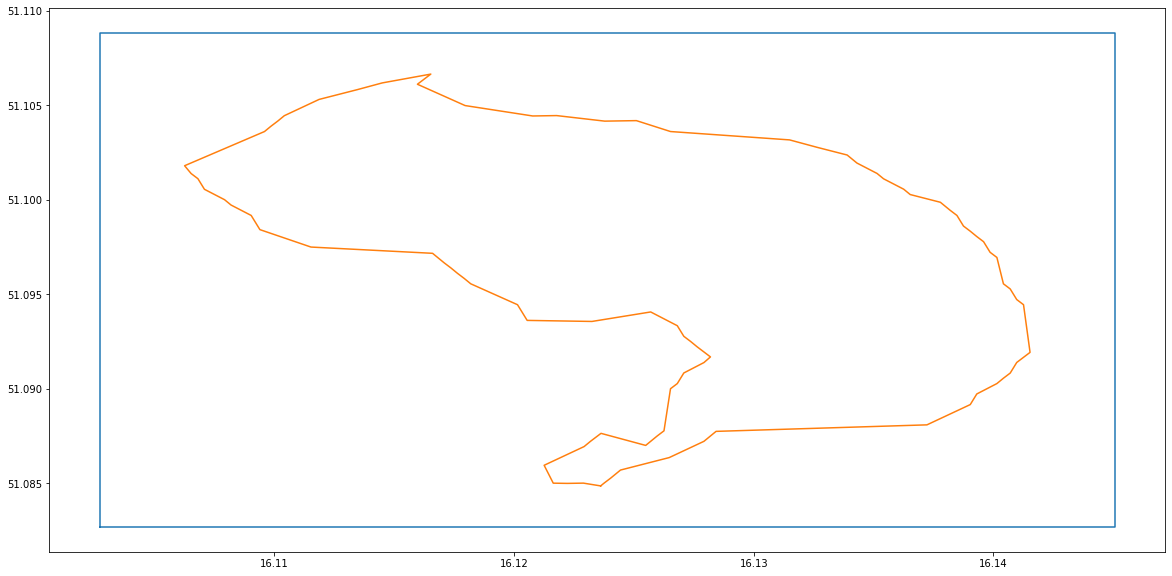

In [23]:
# create BBox instance
bbox = get_bbox(geom, inflate_bbox=0.1)

# plot the BBox and the geometry
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plot_geometry(bbox.geometry, ax)
plot_geometry(geom, ax)

In [24]:
print("Obtained BBox object: ", bbox)

Obtained BBox object:  16.102725552029504,51.08268245442683,16.145052293565968,51.108826334635175


In [37]:
dam_gdf = gpd.GeoDataFrame(geometry=[geom])
dam_gdf.set_crs(epsg=4326, inplace=True)

,geometry
0,"POLYGON ((16.12361 51.08486, 16.12289 51.08501..."


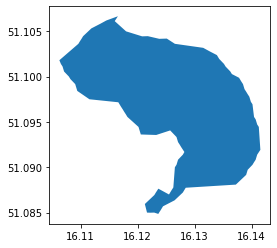

In [38]:
dam_gdf.plot();

In [39]:

download_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=20, 
                                     maxcc=0.5, 
                                     bands=['B02', 'B03', 'B04', 'B08'], 
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'), (FeatureType.MASK, 'CLM')]
                                    )

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

In [40]:
add_nominal_water = VectorToRaster(dam_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

In [41]:

def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

In [42]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):
    
    def execute(self, eopatch):
        
        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape
        
        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch
    
add_coverage = AddValidDataCoverage()

In [43]:
cloud_coverage_threshold = 0.05 

class ValidDataCoveragePredicate:
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        return calculate_coverage(array) < self.threshold
    
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

In [44]:
class WaterDetector(EOTask):
    
    @staticmethod
    def detect_water(ndwi):
        """
        Very simple water detector based on Otsu thresholding method of NDWI.
        """
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) 
                                   for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch
    
water_detection = WaterDetector()

In [45]:
workflow = LinearWorkflow(download_task, calculate_ndwi, add_nominal_water, add_valid_mask,
                          add_coverage, remove_cloudy_scenes, water_detection)

In [46]:
time_interval = ['2015-07-04', '2021-03-06']

In [47]:
result = workflow.execute({
    download_task: {
        'bbox': bbox,
        'time_interval': time_interval
    },
})

In [48]:
patch = list(result.values())[-1]

In [49]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [65]:

def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    
    ax.imshow(2.5*eopatch.data['BANDS'][..., [2, 1, 0]][idx])
    
    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    
    ax.imshow(nominal, cmap=plt.cm.Reds)
    ax.imshow(observed, cmap=plt.cm.Blues)
    ax.axis('off')

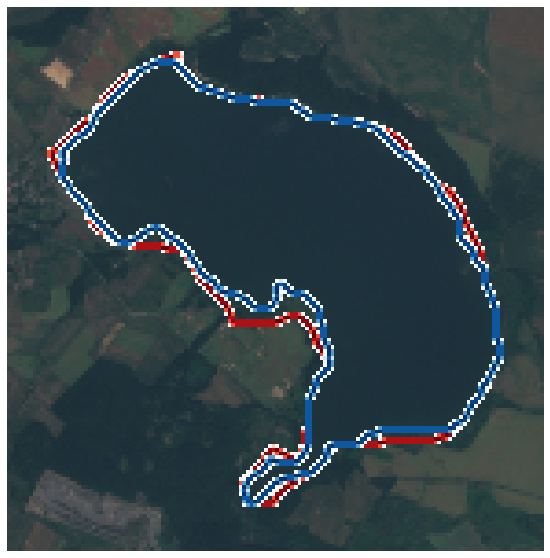

In [66]:
plot_rgb_w_water(patch, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


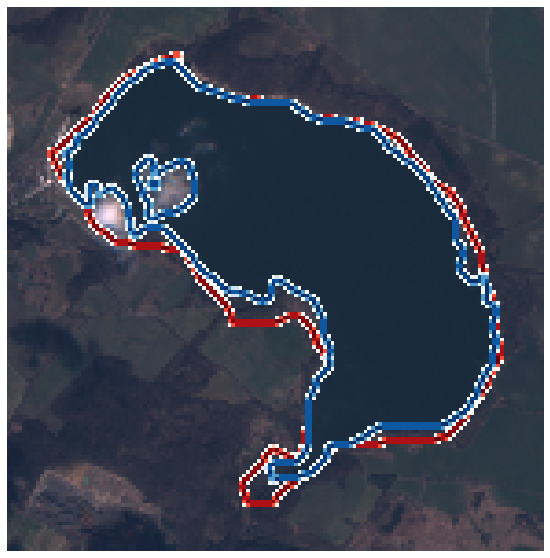

In [52]:
plot_rgb_w_water(patch, -1)

In [53]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20, 7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            'bo-', alpha=0.7)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            '--', color='gray', alpha=0.7)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water level')
    ax.set_title('Theewaterskloof Dam Water Levels')
    ax.grid(axis='y')
    return ax

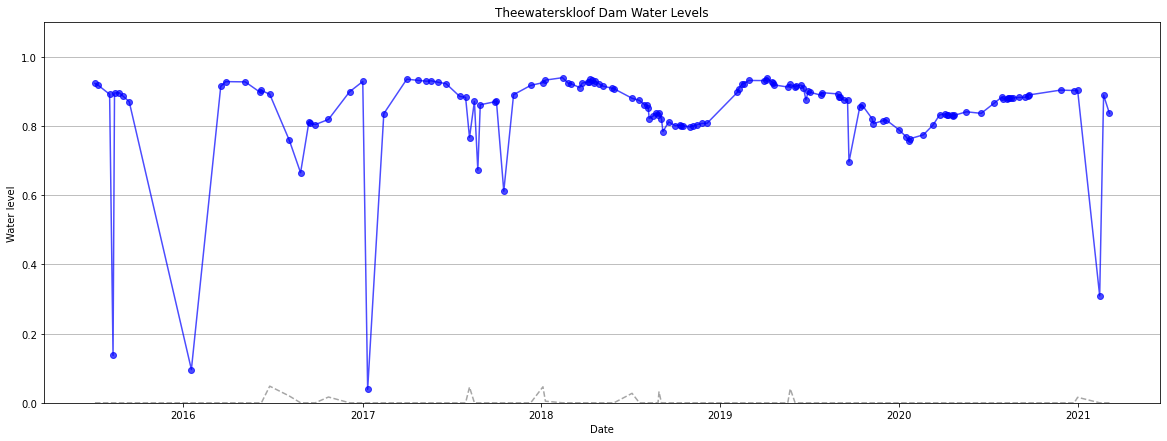

In [54]:
ax = plot_water_levels(patch, 1.0)

In [59]:
patch.scalar['WATER_LEVEL'][...,0]

array([0.92338084, 0.9175956 , 0.89191477, 0.13687033, 0.89572457,
       0.89600677, 0.88697615, 0.87046705, 0.09623254, 0.91491463,
       0.92846056, 0.92775504, 0.89798222, 0.90292084, 0.89191477,
       0.75885424, 0.66516156, 0.81162692, 0.80753492, 0.80414844,
       0.81924651, 0.89896994, 0.92888387, 0.03894455, 0.83589671,
       0.93565684, 0.93198815, 0.92973049, 0.93085932, 0.92690842,
       0.92267532, 0.88570622, 0.88316636, 0.76689714, 0.87103147,
       0.67292225, 0.86157754, 0.87032595, 0.87159588, 0.61168336,
       0.89064484, 0.9175956 , 0.92549739, 0.93283477, 0.93988994,
       0.92352194, 0.92281642, 0.91110484, 0.92408636, 0.92747284,
       0.92846056, 0.93523353, 0.93170594, 0.92563849, 0.9300127 ,
       0.9216876 , 0.91576125, 0.90898829, 0.90800056, 0.88034429,
       0.87413574, 0.86228305, 0.86058981, 0.85113588, 0.82178637,
       0.82884154, 0.83871878, 0.83152251, 0.83660223, 0.82136306,
       0.78425286, 0.81205023, 0.80118527, 0.8025963 , 0.80076

In [60]:
patch.timestamp

[datetime.datetime(2015, 7, 4, 10, 13, 37, tzinfo=tzutc()),
 datetime.datetime(2015, 7, 11, 10, 0, 8, tzinfo=tzutc()),
 datetime.datetime(2015, 8, 3, 10, 10, 10, tzinfo=tzutc()),
 datetime.datetime(2015, 8, 10, 10, 0, 10, tzinfo=tzutc()),
 datetime.datetime(2015, 8, 13, 10, 16, 17, tzinfo=tzutc()),
 datetime.datetime(2015, 8, 23, 10, 10, 19, tzinfo=tzutc()),
 datetime.datetime(2015, 8, 30, 10, 5, 47, tzinfo=tzutc()),
 datetime.datetime(2015, 9, 12, 10, 10, 22, tzinfo=tzutc()),
 datetime.datetime(2016, 1, 17, 10, 10, 30, tzinfo=tzutc()),
 datetime.datetime(2016, 3, 17, 10, 0, 11, tzinfo=tzutc()),
 datetime.datetime(2016, 3, 27, 10, 0, 12, tzinfo=tzutc()),
 datetime.datetime(2016, 5, 6, 10, 5, 27, tzinfo=tzutc()),
 datetime.datetime(2016, 6, 5, 10, 0, 31, tzinfo=tzutc()),
 datetime.datetime(2016, 6, 8, 10, 12, 20, tzinfo=tzutc()),
 datetime.datetime(2016, 6, 25, 10, 6, 17, tzinfo=tzutc()),
 datetime.datetime(2016, 8, 4, 10, 6, 13, tzinfo=tzutc()),
 datetime.datetime(2016, 8, 27, 10, 10, 

In [57]:
patch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(148, 148, 146, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(148, 148, 146, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(148, 148, 146, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(148, 148, 146, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(148, 148, 146, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(148, 148, 146, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(148, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(148, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(148, 146, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 146
    size_y: 148
    time_difference: datetime.timedelta(0, 1)
    time_interval: (datetime.datetime(2015, 7, 4, 0, 0), datetime.datetime(2021, 3, 6, 23, 59, 59))
  }
  bbox: BBox(((16.1